# We will test the Time-shift 1000
- We will use the vanilla model-Baseline (No augmentation)
- We will use the 1000ms augmentation model here

In [1]:
import numpy as np
import scipy.io

from keras import optimizers
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint


import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, Activation
from keras.layers.core import Permute, Reshape
from keras import backend as K

from matplotlib import pyplot as plt
from PIL import Image as img_PIL


# random seed.
rand_seed = 2

from numpy.random import seed
seed(rand_seed)
from tensorflow import set_random_seed
set_random_seed(rand_seed)

Using TensorFlow backend.
/home/nesl/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/nesl/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/nesl/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/nesl/anaconda3/envs/py36/l

## 1. Loading the data

In [2]:
def one_hot_encoding(y_data):
    Mapping=dict()
    sub_dirs=['downstair','upstair','run','jump','walk','handwashing','exercise']

    categories=7

    count=0
    for i in sub_dirs:
        Mapping[i]=count
        count=count+1

    y_features2=[]
    for i in range(len(y_data)):
        Type=y_data[i]
        lab=Mapping[Type]
        y_features2.append(lab)

    y_features=np.array(y_features2)
    y_features=y_features.reshape(y_features.shape[0],1)
    from keras.utils import to_categorical
    y_features = to_categorical(y_features)

    return y_features

In [3]:
path='data/'


def get_train_data(path=path):
    Train_data=np.load(path+'train_5000.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

def get_valid_data(path=path):
    Train_data=np.load(path+'valid_1000.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

def get_test_data(path=path):
    Train_data=np.load(path+'test_1377.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']

    Labels = one_hot_encoding(Labels)
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound


In [4]:
Features_imu,Labels,Features_sound = get_train_data()
print(Features_imu.shape, Labels.shape, Features_sound.shape)
print('Train Classes distribution: ',np.sum(Labels, axis =0))

Features_imu2,Labels2,Features_sound2 = get_valid_data()
print(Features_imu2.shape, Labels2.shape, Features_sound2.shape)
print('Valid Classes distribution: ',np.sum(Labels2, axis =0))

Features_imu3,Labels3,Features_sound3 = get_test_data()
print(Features_imu3.shape, Labels3.shape, Features_sound3.shape)
print('Test Classes distribution: ',np.sum(Labels3, axis =0))

(5000, 1, 40, 12) (5000, 7) (5000, 193)
Train Classes distribution:  [760. 994. 546. 780. 532. 732. 656.]
(1000, 1, 40, 12) (1000, 7) (1000, 193)
Valid Classes distribution:  [150. 188. 136. 141.  98. 157. 130.]
(1377, 1, 40, 12) (1377, 7) (1377, 193)
Test Classes distribution:  [219. 268. 124. 146. 143. 234. 243.]


In [5]:
model_path = 'data/IMU_Audio_Fusion_1000ms'

from keras.models import load_model

model = load_model(model_path)

In [6]:
## Test Accuracy
model.evaluate([Features_sound3,Features_imu3],Labels3)

1377/1377 [==============================] - 2s 1ms/step


[0.10806767817294642, 0.9724037763253449]

## Observation: All of these test labels are continuous.
### Time window used to create a sample: 2 Second.

# Time shifting, our goal is to randomly insert the samples of different continuous windows in between which is to simulate the real-time deployment setting

# First preprocess the data to get the continuous acc and gyro windows
- data ordering: 12 sensors each with 40 samples.
- 12 sensors are: acc_right, gyro_right, acc_left, gyro_left

In [7]:
def get_test_data2(path=path):
    Train_data=np.load(path+'test_1377.npz')
    Features_imu=Train_data['arr_0']
    Labels=Train_data['arr_1']
    Features_sound=Train_data['arr_2']
    
    Features_imu = Features_imu.reshape(Features_imu.shape[0],1, Features_imu.shape[1], Features_imu.shape[2]) 

    return Features_imu,Labels,Features_sound

In [8]:
Features_imu_t1,Labels_t1,Features_sound_t1 = get_test_data2()
print(Features_imu_t1.shape, Labels_t1.shape, Features_sound_t1.shape)

(1377, 1, 40, 12) (1377,) (1377, 193)


In [9]:
# We see all of the labels are continuous
Labels_t1 = np.array(Labels_t1)

In [10]:
Labels_t1[:100]

array(['downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'downstair', 'downstair', 'down

# Getting windows of data together with num_windows_together in each

In [12]:
# For 10 second together
num_windows_together = 5

curr_indx = 0
final_indx = Features_imu_t1.shape[0]

data_together = []

while curr_indx <= final_indx:
    IMU_together   = Features_imu_t1[curr_indx:curr_indx+num_windows_together]
    sound_together = Features_sound_t1[curr_indx:curr_indx+num_windows_together]
    labels_together = Labels_t1[curr_indx:curr_indx+num_windows_together]
    
    data_together.append([IMU_together,sound_together,labels_together])
    
    curr_indx = curr_indx+num_windows_together
    

# Now we randomly distribute the windows

In [13]:
rand_seed = 4
from numpy.random import seed
seed(rand_seed)

ordering = np.arange(len(data_together))
np.random.shuffle(ordering)

In [14]:
ordering[:100]

array([166, 225, 146, 215,  82,  46,  18, 113, 253,  47, 171, 275,   6,
       123, 250, 232, 203, 124,  45, 133, 111,  24,   1, 159, 212, 101,
       137, 128, 139, 256,  33,  11, 106,  68,  39,  69, 110,  43,  83,
       108, 169,  64, 223, 189, 134,  88, 235,  93, 191, 260, 249, 271,
       254, 100,  92,  71, 103,  63, 267, 144,  13,  42,  14, 268, 182,
       140,  84,  48, 130,  55, 184, 152, 251, 178,  20, 175, 129, 266,
       269, 218, 227, 193, 261,  91, 216, 162, 229, 116, 121,  34, 233,
       112, 247, 231, 239, 153,  57,  81,  70,  26])

## Now we again recreate the test data

In [15]:
indx = ordering[0]

Features_imu_t1  = data_together[indx][0]
Features_sound_t1 = data_together[indx][1]
Labels_t1 = data_together[indx][2]


#print(Features_imu_t1.shape,Labels_t1.shape,Features_sound_t1.shape)

for i in range(1, len(data_together)):
    indx = ordering[i]
    IMU_together  = data_together[indx][0]
    sound_together= data_together[indx][1]
    labels_together=data_together[indx][2]
    #print(indx, IMU_together.shape,sound_together.shape,labels_together.shape)
    Features_imu_t1 = np.concatenate((Features_imu_t1,IMU_together),axis=0)
    Labels_t1 = np.concatenate((Labels_t1,labels_together),axis=0)
    Features_sound_t1 = np.concatenate((Features_sound_t1,sound_together),axis=0)
    #print(indx, IMU_together.shape,sound_together.shape,labels_together.shape)

In [16]:
print(Features_imu_t1.shape, Labels_t1.shape, Features_sound_t1.shape)

(1377, 1, 40, 12) (1377,) (1377, 193)


In [17]:
Labels_t1[:100]

array(['walk', 'walk', 'walk', 'walk', 'walk', 'handwashing',
       'handwashing', 'handwashing', 'handwashing', 'handwashing', 'jump',
       'jump', 'jump', 'jump', 'jump', 'handwashing', 'handwashing',
       'handwashing', 'handwashing', 'handwashing', 'upstair', 'upstair',
       'upstair', 'upstair', 'upstair', 'upstair', 'upstair', 'upstair',
       'upstair', 'upstair', 'downstair', 'downstair', 'downstair',
       'downstair', 'downstair', 'run', 'run', 'run', 'run', 'run',
       'exercise', 'exercise', 'exercise', 'exercise', 'exercise',
       'upstair', 'upstair', 'upstair', 'upstair', 'upstair', 'walk',
       'walk', 'walk', 'walk', 'walk', 'exercise', 'exercise',
       'downstair', 'downstair', 'downstair', 'downstair', 'downstair',
       'jump', 'jump', 'jump', 'jump', 'jump', 'exercise', 'exercise',
       'exercise', 'exercise', 'exercise', 'exercise', 'exercise',
       'exercise', 'exercise', 'exercise', 'handwashing', 'handwashing',
       'handwashing', 'handw

In [18]:
Labels_t1 = one_hot_encoding(Labels_t1)

# Testing accuracy on Reshuffled data.
## Note: not time errors are introduced so Accuracy should be same as the fusion model on original continuous test data

In [19]:
model.evaluate([Features_sound_t1,Features_imu_t1],Labels_t1)

1377/1377 [==============================] - 1s 986us/step


[0.10806768087495676, 0.9724037763253449]

# Now aggregating the data and doing the timing errors

In [20]:
acc_right=[]
gyro_right=[]
acc_left=[]
gyro_left=[]

for i in range(Features_imu_t1.shape[0]):
    acc_right.append([Features_imu_t1[i,0,:,0],Features_imu_t1[i,0,:,1],Features_imu_t1[i,0,:,2]])
    gyro_right.append([Features_imu_t1[i,0,:,3],Features_imu_t1[i,0,:,4],Features_imu_t1[i,0,:,5]])
    acc_left.append([Features_imu_t1[i,0,:,6],Features_imu_t1[i,0,:,7],Features_imu_t1[i,0,:,8]])
    gyro_left.append([Features_imu_t1[i,0,:,9],Features_imu_t1[i,0,:,10],Features_imu_t1[i,0,:,11]])
        

In [21]:
acc_right=np.array(acc_right)
gyro_right=np.array(gyro_right)
acc_left=np.array(acc_left)
gyro_left=np.array(gyro_left)

In [22]:
print(acc_right.shape)
print(gyro_right.shape)
print(acc_left.shape)
print(gyro_left.shape)

(1377, 3, 40)
(1377, 3, 40)
(1377, 3, 40)
(1377, 3, 40)


In [23]:
acc_right_cont= acc_right[0,]
gyro_right_cont= gyro_right[0,]

acc_left_cont= acc_left[0,]
gyro_left_cont= gyro_left[0,]


for i in range(1, Features_imu_t1.shape[0]):
    #print(i)
    acc_right_cont=np.hstack((acc_right_cont,acc_right[i,]))
    gyro_right_cont=np.hstack((gyro_right_cont,gyro_right[i,]))
    acc_left_cont=np.hstack((acc_left_cont,acc_left[i,]))
    gyro_left_cont=np.hstack((gyro_left_cont,gyro_left[i,]))

In [24]:
print(acc_right_cont.shape)
print(gyro_right_cont.shape)
print(acc_left_cont.shape)
print(gyro_left_cont.shape)


(3, 55080)
(3, 55080)
(3, 55080)
(3, 55080)


# Now shifting the samples

# Defining function to do the evaluation

In [27]:
def get_data_sample_shift(shift_samples = 1):
    sample_size = 40 #need to be 40, as decided during training
    total_samples = acc_right_cont.shape[1]
    
    #print(total_samples)
    
    current_cursor = shift_samples

    i = 0

    acc_right_pro= np.array(acc_right_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])

    #print(acc_right_pro.shape)

    gyro_right_pro= np.array(gyro_right_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])

    acc_left_pro= np.array(acc_left_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])

    gyro_left_pro= np.array(gyro_left_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])

    #print(np.array(acc_right_cont[np.newaxis,:,current_cursor:current_cursor+sample_size]).shape)

    while current_cursor<=(total_samples-2*sample_size):
        current_cursor = current_cursor + sample_size
        #print(current_cursor," : ", i)
        a=acc_right_pro
        b=np.array(acc_right_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])
        acc_right_pro = np.concatenate((a,b),axis=0)


        a=gyro_right_pro
        b=np.array(gyro_right_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])
        gyro_right_pro = np.concatenate((a,b),axis=0)


        a=acc_left_pro
        b=np.array(acc_left_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])
        #print(a.shape,b.shape)
        acc_left_pro = np.concatenate((a,b),axis=0)

        a=gyro_left_pro
        b=np.array(gyro_left_cont[np.newaxis,:,current_cursor:current_cursor+sample_size])
        gyro_left_pro = np.concatenate((a,b),axis=0)
        i = i+1
        
    IMU_processed = np.concatenate((acc_right_pro,gyro_right_pro,acc_left_pro,gyro_left_pro),axis=1)
    IMU_processed = IMU_processed[:,np.newaxis,:,:]
    IMU_processed = np.swapaxes(IMU_processed,2,3)
        
    size = IMU_processed.shape[0]
        
    return Features_sound_t1[:size], IMU_processed ,Labels_t1[:size]
        


In [31]:
Accuracy_vanilla = []
Accuracy_1000ms = []

In [32]:
model_path1 = 'data/Baseline_IMU_Audio_Fusion'
model_path2 = 'data/IMU_Audio_Fusion_1000ms'

from keras.models import load_model
model1 = load_model(model_path1)
model2 = load_model(model_path2)

In [33]:
for shift in range(41):
    Features_sound, IMU ,Labels =  get_data_sample_shift(shift_samples = shift)
    evaluation1 = model1.evaluate([Features_sound,IMU],Labels)
    Accuracy_vanilla.append(evaluation1[1])
    
    evaluation2 = model2.evaluate([Features_sound,IMU],Labels)
    Accuracy_1000ms.append(evaluation2[1])
    
    print("Shift is:",shift,evaluation1[1],evaluation2[1])

1377/1377 [==============================] - 2s 1ms/step
Shift is: 0 0.9607843137254902 0.9724037763253449
1376/1376 [==============================] - 1s 919us/step
Shift is: 1 0.9593023255813954 0.970203488372093
1376/1376 [==============================] - 1s 920us/step
Shift is: 2 0.9476744186046512 0.970203488372093
1376/1376 [==============================] - 1s 926us/step
Shift is: 3 0.9454941860465116 0.967296511627907
1376/1376 [==============================] - 1s 936us/step
Shift is: 4 0.9367732558139535 0.970203488372093
1376/1376 [==============================] - 1s 868us/step
Shift is: 5 0.934593023255814 0.9643895348837209
1376/1376 [==============================] - 1s 865us/step
Shift is: 6 0.9338662790697675 0.9622093023255814
1376/1376 [==============================] - 1s 998us/step
Shift is: 7 0.9265988372093024 0.9607558139534884
1376/1376 [==============================] - 1s 958us/step
Shift is: 8 0.9280523255813954 0.9607558139534884
1376/1376 [===============

In [34]:
Accuracy_vanilla

[0.9607843137254902,
 0.9593023255813954,
 0.9476744186046512,
 0.9454941860465116,
 0.9367732558139535,
 0.934593023255814,
 0.9338662790697675,
 0.9265988372093024,
 0.9280523255813954,
 0.9200581395348837,
 0.9164244186046512,
 0.9127906976744186,
 0.9055232558139535,
 0.9084302325581395,
 0.8968023255813954,
 0.8938953488372093,
 0.8938953488372093,
 0.8975290697674418,
 0.9004360465116279,
 0.8880813953488372,
 0.8815406976744186,
 0.8684593023255814,
 0.8713662790697675,
 0.8713662790697675,
 0.8699127906976745,
 0.8699127906976745,
 0.8662790697674418,
 0.8619186046511628,
 0.8640988372093024,
 0.846656976744186,
 0.8401162790697675,
 0.846656976744186,
 0.8415697674418605,
 0.8343023255813954,
 0.8343023255813954,
 0.8321220930232558,
 0.8328488372093024,
 0.8343023255813954,
 0.8321220930232558,
 0.8321220930232558,
 0.8277616279069767]

In [35]:
Accuracy_1000ms

[0.9724037763253449,
 0.970203488372093,
 0.970203488372093,
 0.967296511627907,
 0.970203488372093,
 0.9643895348837209,
 0.9622093023255814,
 0.9607558139534884,
 0.9607558139534884,
 0.9578488372093024,
 0.9593023255813954,
 0.9593023255813954,
 0.9578488372093024,
 0.9571220930232558,
 0.9549418604651163,
 0.9491279069767442,
 0.9469476744186046,
 0.9418604651162791,
 0.9447674418604651,
 0.9425872093023255,
 0.9462209302325582,
 0.9338662790697675,
 0.9324127906976745,
 0.9215116279069767,
 0.9229651162790697,
 0.9215116279069767,
 0.9229651162790697,
 0.9156976744186046,
 0.9098837209302325,
 0.9040697674418605,
 0.8953488372093024,
 0.8960755813953488,
 0.8909883720930233,
 0.8880813953488372,
 0.8866279069767442,
 0.8837209302325582,
 0.8859011627906976,
 0.8808139534883721,
 0.8742732558139535,
 0.8662790697674418,
 0.8670058139534884]

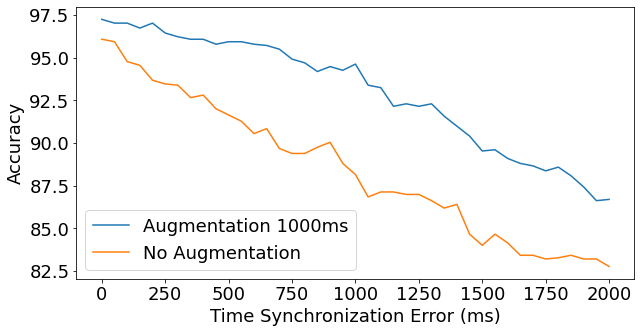

In [37]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 18})

y = np.arange(len(Accuracy_vanilla[:41]))

y = y * 50

plt.plot(y,(np.array(Accuracy_1000ms[:41])*100))
plt.plot(y,(np.array(Accuracy_vanilla[:41])*100))

#plt.title('Fused Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Time Synchronization Error (ms)')
plt.legend(['Augmentation 1000ms','No Augmentation'], loc='lower left')
plt.show()